# Комаров Данил ИАД-2

# Домашнее задание 6: классификация текстов

В этом домашнем задании вам предстоит построить классификатор текстов!

Данные мы будем использовать из Kaggle соревнования: https://www.kaggle.com/competitions/nlp-getting-started/data Оттуда надо скачать файл train.csv. На обучающую и тестовую выборки его поделим кодом ниже, менять его не надо!

Мы будем работать с датасетом постов из твиттера. Нам предстоит решать задачу бинарной классификации - определять содержатся ли в твитте информация о настоящей катастрофе/инциденте или нет.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import svm
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('train.csv')

In [3]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
train, test = train_test_split(data, test_size=0.3, random_state=42)

## Задание 1 (0.5 балла)

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [5]:
train.info() # пропуски в обучающей выборке есть

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5329 entries, 1186 to 7270
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        5329 non-null   int64 
 1   keyword   5285 non-null   object
 2   location  3569 non-null   object
 3   text      5329 non-null   object
 4   target    5329 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 249.8+ KB


In [6]:
test.info() # пропуски в тестовой выборке есть

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2284 entries, 2644 to 6753
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        2284 non-null   int64 
 1   keyword   2267 non-null   object
 2   location  1511 non-null   object
 3   text      2284 non-null   object
 4   target    2284 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 107.1+ KB


In [7]:
train['keyword'] = train['keyword'].fillna('')
train['location'] = train['location'].fillna('')

test['keyword'] = test['keyword'].fillna('')
test['location'] = test['location'].fillna('')

In [8]:
train.isnull().any().any() # пропусков в обучающей выборке не осталось

False

In [9]:
test.isnull().any().any() # пропусков в тестовой выборке не осталось

False

## Задание 2 (1 балл)
Давайте немного посмотрим на наши данные. Визуализируйте (где явно просят) или выведете информацию о следующем:

1. Какое распределение классов в обучающей выборке?
2. Посмотрите на колонку "keyword" - возьмите 10 наиболее встречающихся значений, постройте ступенчатую диаграмму распределения классов в зависимости от значения keyword, сделайте выводы.

In [10]:
# Вопрос 1.
# в целом классы достаточно сбалансированы, сильного дисбаланса нет
print(f'0 класс: {100*round(train[train["target"] == 0].shape[0] / train.shape[0], 6)}%\n1 класс: {100*round(train[train["target"] == 1].shape[0] / train.shape[0], 6)}%')

0 класс: 56.7461%
1 класс: 43.2539%


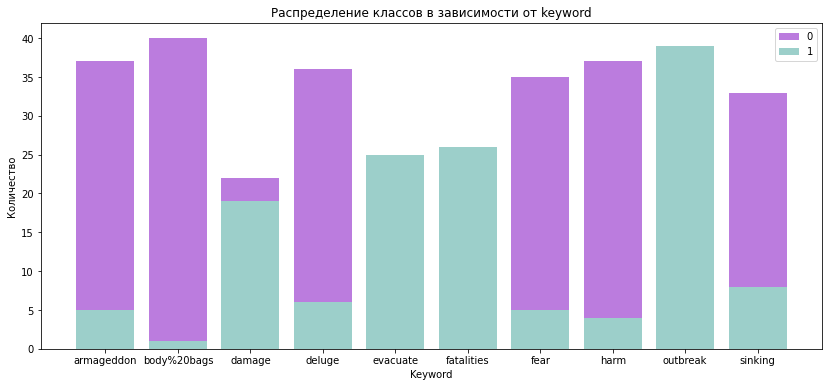

In [11]:
# Вопрос 2.
top_keywords = data[data['keyword'].isin(data['keyword'].value_counts()[:10].index.tolist())]
top_groupby = top_keywords.groupby(['keyword', 'target'], as_index=False).agg('count')

fig, ax = plt.subplots(figsize=(14, 6))

ax.bar(np.unique(top_groupby['keyword']), top_groupby[top_groupby['target'] == 0]['id'].values, label='0', color='#BB7CDE')
ax.bar(np.unique(top_groupby['keyword']), top_groupby[top_groupby['target'] == 1]['id'].values,
       label='1', color='#9CCFCA')
ax.set_title('Распределение классов в зависимости от keyword')
ax.set_xlabel('Keyword')
ax.set_ylabel('Количество')
ax.legend();

**Вывод**: в зависимости от ключевого слова в твите значительно изменяется распределение классов, видно, что в более агрессивных и трагических словах класс 1 преобладает

## Задание 3 (0.5 балла) 

В этом задании предлагается объединить все три текстовых столбца в один (просто сконкатенировать cтроки) и убрать столбец с индексом.

In [12]:
def prepare_data(data): 
    data['all_text'] = data['keyword'] + ' ' + data['location'] + ' ' + data['text']
    data['all_text'] = data['all_text'].apply(lambda x: x.replace('  ', ' '))    
    data.drop(['id', 'keyword', 'location', 'text'], axis=1, inplace=True) 
    return data

In [13]:
train = prepare_data(train)
test = prepare_data(test)

## Задание 4 (0.5 балла)

Далее мы будем пока работать только с train частью.

1. Предобработайте данные (train часть) с помощью CountVectorizer.
2. Какого размера получилась матрица?


In [14]:
# Вопрос 1.
vectorizer = CountVectorizer()
vectorizer.fit(train['all_text'])
train_vect = vectorizer.transform(train['all_text'])

In [15]:
# Вопрос 2.
train_vect.shape

(5329, 18455)

## Задание 5 (1 балл)

В предыдущем пункте у вас должна была получиться достаточно большая матрица.
Если вы взгляните на текст, то увидете, что там есть множество специальных символов, ссылок и прочего мусора.

Давайте также посмотрим на словарь, который получился в результате построения CountVectorizer, его можно найти в поле vocabulary_ инстанса этого класса. Давайте напишем функцию, которая печает ответы на следующие вопросы:

1. Найдите в этом словаре все слова, которые содержат цифры. Сколько таких слов нашлось?

2. Найдите все слова, которые содержат символы пунктуации. Сколько таких слов нашлось? 

3. Сколько хэштегов (токен начинается на #) и упоминаний (токен начинается на @) осталось в словаре?

In [16]:
def answer_func(vectorizer):
    print(f'Вопрос 1. Количество слов, содержащих цифры - {sum(map(lambda x: x.isdigit(), vectorizer.vocabulary_))}')
    print(f'ВОпрос 2. Количество слов, содержащих символы пунктуации - {sum(map(lambda x: not set(string.punctuation).isdisjoint(x), vectorizer.vocabulary_))}')
    print(f'Вопрос 3. Количество слов, начинающихся с # или @ - {sum(map(lambda x: x.startswith("@")|x.startswith("#"), vectorizer.vocabulary_))}') 
    return

In [17]:
answer_func(vectorizer)

Вопрос 1. Количество слов, содержащих цифры - 387
ВОпрос 2. Количество слов, содержащих символы пунктуации - 315
Вопрос 3. Количество слов, начинающихся с # или @ - 0


## Задание 6 (0.5 балла)

Вспомним, что на семинаре по текстам мы узнали, что в nltk есть специальный токенизатор для текстов - TweetTokenizer. Попробуем применить CountVectorizer с этим токенизатором. Ответьте на все вопросы из предыдущего пункта для TweetTokenizer и сравните результаты.

In [18]:
tw_tokenizer = TweetTokenizer()

In [19]:
cnt_vect_tw = CountVectorizer(tokenizer=lambda x: tw_tokenizer.tokenize(x))
cnt_vect_tw.fit(train['all_text'])
train_vect_tw = cnt_vect_tw.transform(train['all_text'])

In [20]:
train_vect_tw.shape

(5329, 19670)

In [21]:
answer_func(cnt_vect_tw)

Вопрос 1. Количество слов, содержащих цифры - 303
ВОпрос 2. Количество слов, содержащих символы пунктуации - 7338
Вопрос 3. Количество слов, начинающихся с # или @ - 3149


## Задание 7 (2 балла)

В scikit-learn мы можем оценивать процесс подсчета матрицы через CountVectorizer. У CountVectorizer, как и у других наследников \_VectorizerMixin, есть аргумент tokenizer и preprocessor. preprocessor применится в самом начале к каждой строке вашего датасета, tokenizer же должен принять строку и вернуть токены.
Давайте напишем кастомный токенайзер, которые сделает все, что нам нужно: 

0. Приведет все буквы к нижнему регистру
1. Разобьет текст на токены с помощью TweetTokenizer из пакета nltk
2. Удалит все токены содержащие не латинские буквы, кроме смайликов (будем считать ими токены содержащие только пунктуацию и, как минимум, одну скобочку) и хэштегов, которые после начальной # содержат только латинские буквы.
3. Удалит все токены, которые перечислены в nltk.corpus.stopwords.words('english')
4. Проведет стемминг с помощью SnowballStemmer

Продемонстрируйте работу вашей функции на первых десяти текстах в обучающей выборке.

In [22]:
# стемминг
snowball = SnowballStemmer('english')

In [23]:
def tw_tokenizer_stem(string):
    # изменяем регистр
    string = string.lower()
    # применяем TweetTokenizer
    tokens = tw_tokenizer.tokenize(string)
    # удаляем ненужные слова + применяем SnowballStemmer
    stem_tokens = [snowball.stem(token) for token in tokens 
              # успел сделать только регулярку, которая оставляет исключительно латинские буквы
              if token == re.sub("[^a-z]", "", token) and token not in stopwords.words('english')]
    
    
    return stem_tokens

In [24]:
train['all_text'][:10].apply(tw_tokenizer_stem)

1186    [bridg, ash, australia, collaps, trent, bridg,...
4071    [hail, carol, stream, illinoi, great, michigan...
5461    [polic, houston, cnn, tennesse, movi, theater,...
5787        [riot, still, riot, coupl, hour, left, class]
7445    [wound, lake, highland, crack, path, wipe, mor...
151     [airplan, somewher, expert, franc, begin, exam...
915     [bloodi, isol, citi, world, perth, came, kill,...
1305                    [burn, except, idk, realli, burn]
2570                        [destroy, ask, destroy, hous]
7399    [wound, maracay, nirgua, venezuela, polic, off...
Name: all_text, dtype: object

## Задание 8 (1 балл)

1. Примените CountVectorizer с реализованным выше токенизатором к обучающим и тестовым выборкам.
2. Обучите LogisticRegression на полученных признаках.
3. Посчитайте метрику f1-score на тестовых данных.

In [25]:
def logreg(train_vect, test_vect):
    logreg = LogisticRegression()
    logreg.fit(train_vect, train["target"])
    y_pred = logreg.predict(test_vect)
    return f'f1 score: {f1_score(test["target"], y_pred)}'

In [26]:
cnt_vect_stem = CountVectorizer(tokenizer=tw_tokenizer_stem)
train_cnt_vect = cnt_vect_stem.fit_transform(train['all_text'])
test_cnt_vect = cnt_vect_stem.transform(test['all_text'])

In [27]:
logreg(train_cnt_vect, test_cnt_vect)

'f1 score: 0.7482555018786903'

## Задание 9 (1 балл)

1. Повторите 7 задание, но с tf-idf векторизатором. Как изменилось качество?
2. Мы можем еще сильнее уменьшить размер нашей матрицы, если отбросим значения df близкие к единице. Скорее всего такие слова не несут много информации о категории, так как встречаются достаточно часто. Ограничьте максимальный df в параметрах TfIdfVectorizer, поставьте верхнюю границу равную 0.9. Как изменился размер матрицы, как изменилось качество?
3. Также мы можем уменьшить размер матрицы, удаляя слова со слишком маленьким df. Удалось ли добиться улучшения качества? 

#### 1. Baseline TfidfVectorizer

In [28]:
tfidf = TfidfVectorizer(tokenizer=tw_tokenizer_stem)
train_tfidf_vect = tfidf.fit_transform(train['all_text'])
test_tfidf_vect = tfidf.transform(test['all_text'])

In [29]:
logreg(train_tfidf_vect, test_tfidf_vect)

'f1 score: 0.7433333333333335'

In [30]:
# Размер словаря
len(tfidf.vocabulary_)

9148

#### 2. TfidfVectorizer with max_df=0.9

In [31]:
tfidf_cut = TfidfVectorizer(tokenizer=tw_tokenizer_stem, max_df=0.9)
train_tfidf_cut_vect = tfidf_cut.fit_transform(train['all_text'])
test_tfidf_cut_vect = tfidf_cut.transform(test['all_text'])

In [32]:
logreg(train_tfidf_cut_vect, test_tfidf_cut_vect) # качество не изменилось

'f1 score: 0.7433333333333335'

In [33]:
# Размер словаря не изменился
len(tfidf_cut.vocabulary_)

9148

#### 3. TfidfVectorizer with max_df=0.9 and min_df=10

In [34]:
tfidf_cut2 = TfidfVectorizer(tokenizer=tw_tokenizer_stem, max_df=0.9, min_df=10)
train_tfidf_cut2_vect = tfidf_cut2.fit_transform(train['all_text'])
test_tfidf_cut2_vect = tfidf_cut2.transform(test['all_text'])

In [35]:
logreg(train_tfidf_cut2_vect, test_tfidf_cut2_vect) # при увеличении min_df качество уменьшается

'f1 score: 0.7325013564839935'

In [36]:
# Размер словаря уменьшился из-за отсечения редких токенов
len(tfidf_cut2.vocabulary_)

1098

**Вывод:** Качество увеличить не удалось

## Задание 10 (1 балл)

Еще один популяпный трюк, который позволит уменьшить количество признаков называется hashing trick. Его суть в том, то мы случайно группируем признаки ииии  ..... складываем их! А потом удаляем исходные признаки. В итоге все наши признаки это просто суммы исходных. Звучит странно, но это отлично работает. Давайте проверим этот трюк в нашем сеттинге.
Также при таком подходе вам не нужно хранить словарь token->index, что тоже иногда полезно.

1. Повторите задание 7 с HashingVectorizer, укажите количество фичей равное 5000.
2. Какой из подходов показал самый высокий результат?

In [37]:
hashing = HashingVectorizer(tokenizer=tw_tokenizer_stem, n_features=5000)
hashing.fit(train['all_text'])
train_hashing_vect = hashing.transform(train['all_text'])
test_hashing_vect = hashing.transform(test['all_text'])

In [38]:
logreg(train_hashing_vect, test_hashing_vect)

'f1 score: 0.7154017857142856'

###  Вывод:

Самый лучший результат показал **Countvectorizer** с кастомным токенизатором - **f1_score = 0.7483**

## Задание 11 (1 балл)

В этом задании нужно добиться f1 меры хотя в 0.75 на тестовых данных.

In [39]:
def models_zoo(train_vect, test_vect):
    
    models_results = {}
    
    logreg = LogisticRegression()
    logreg.fit(train_vect, train['target'])
    y_pred_logreg = logreg.predict(test_vect)
    models_results['logreg'] = f1_score(test["target"], y_pred_logreg)
    
    sgd = SGDClassifier()
    sgd.fit(train_vect, train['target'])
    y_pred_sgd = sgd.predict(test_vect)
    models_results['sgd'] = f1_score(test["target"], y_pred_sgd)
    
    rf = RandomForestClassifier()
    rf.fit(train_vect, train['target'])
    y_pred_rf = rf.predict(test_vect)
    models_results['rf'] = f1_score(test["target"], y_pred_rf)
    
    gb = GradientBoostingClassifier()
    gb.fit(train_vect, train['target'])
    y_pred_gb = gb.predict(test_vect)
    models_results['gb'] = f1_score(test["target"], y_pred_gb)
    
    svm_m = svm.SVC()
    svm_m.fit(train_vect, train['target'])
    y_pred_svm = svm_m.predict(test_vect)
    models_results['svm'] = f1_score(test["target"], y_pred_svm)
    
    return sorted(models_results.items(), key=lambda x: x[1], reverse=True)

In [40]:
results = models_zoo(train_cnt_vect, test_cnt_vect)

In [41]:
results

[('logreg', 0.7482555018786903),
 ('svm', 0.7422096317280453),
 ('rf', 0.7195530726256982),
 ('sgd', 0.7116692830978545),
 ('gb', 0.6282383419689118)]

In [42]:
def best_params_log(X, y, scoring, solver=['lbfgs']):
    parameters = {
                'penalty' : ['l1','l2'], 
                'class_weight' : ['balanced', None], 
                'C' : [0.01, 0.1, 0.5, 1, 5, 10],
                'solver': solver
                }
    log_cv = GridSearchCV(LogisticRegression(), parameters, cv=5, scoring=scoring)
    log_cv.fit(X, y)

    best_parameters = log_cv.best_params_
    print('The best parameters for using this model is', best_parameters)

In [43]:
best_params_log(train_cnt_vect, train['target'], scoring='f1')

The best parameters for using this model is {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}


In [44]:
logreg = LogisticRegression(C=0.1, class_weight='balanced', )
logreg.fit(train_cnt_vect, train['target'])
y_pred_logreg = logreg.predict(test_cnt_vect)
print(f'f1 score: {f1_score(test["target"], y_pred_logreg)}')

f1 score: 0.7541666666666668


### Вывод:

Удалось достичь качества больше 0.75 на LogisticRegression при прогонке GridSearchCV и подборке лучших параметров